# Model 1 <>

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


### V1.0
结构：随机森林+随机森林+随机森林

发现：
1) classifier表现很好，10个随机树时就有很好的分类表现了。
2) progressor表现尚可
3) 预测28年奖牌榜时效果很差，猜测是由于当届参数过多，而预测模型不太行。

In [23]:
class OlympicPredictionModel:
    def __init__(self, lambda_weight=0.3, mu_weight=0.85):
        """
        Initialize model weights
        :param lambda_weight: Small country weight
        :param mu_weight: Large country weight
        """
        self.lambda_weight = lambda_weight
        self.mu_weight = mu_weight
        self.classifier = RandomForestClassifier(n_estimators=200)
        self.regressor1 = RandomForestRegressor(n_estimators=200)
        self.regressor2 = RandomForestRegressor(n_estimators=200)
        self.lstm_models = {}

    @staticmethod
    def calculate_w4_vector(country_change, athlete_change, event_changes):
        """
        Vectorized calculation of W4
        """
        w1 = np.sum(country_change, axis=1).astype(np.float64)
        w2 = np.sum(athlete_change, axis=1).astype(np.float64)
        w3 = np.sum(event_changes, axis=1).astype(np.float64)
        w4 = np.divide(0.2 * w1 + 0.8 * w2, w3, out=np.zeros_like(w3, dtype=np.float64), where=w3 != 0)
        return w4

    def preprocess_data(self, data):
        """
        Preprocess data, including calculating features A, B, and C
        """
        # Feature A
        score_rate_list = np.array(data['Score_Rate_List'].apply(eval).tolist())
        score_list = np.array(data['Score_List'].apply(eval).tolist(), dtype=np.float64)
        participants_list = np.array(data['Participants_List'].apply(eval).tolist(), dtype=np.float64)

        v5_5_a = np.sum(score_rate_list, axis=1)
        v8_5_a = np.sum(np.divide(score_list, participants_list, 
                                  out=np.zeros_like(score_list, dtype=np.float64), 
                                  where=participants_list > 0), axis=1)

        country_change = np.array(data['CountryChange'].apply(eval).tolist())
        athlete_change = np.array(data['AthleteChange'].apply(eval).tolist())
        event_changes = np.array(data['Event_Changes'].apply(eval).tolist())
        w4 = self.calculate_w4_vector(country_change, athlete_change, event_changes)

        v8_w4 = np.sum(np.multiply(
            np.divide(score_list, participants_list, out=np.zeros_like(score_list, dtype=np.float64), where=participants_list > 0),
            w4[:, None]
        ), axis=1)

        features_a = np.column_stack((v5_5_a, v8_5_a, v8_w4))

        # Feature B
        v1_b = data['if_host'].values
        v5_5_b = np.sum(participants_list, axis=1)
        v6_b = data['Gold_prev'].fillna(0).values
        v7_b = data['distance'].values
        v3_5_b = data['Score'].values
        v3_w4_b = np.sum(np.multiply(score_list, w4[:, None]), axis=1)

        features_b = np.column_stack((v1_b, v5_5_b, v6_b, v7_b, v3_5_b, v3_w4_b))

        # Feature C (same as B)
        features_c = features_b.copy()

        # Labels and expectations
        labels = (data['Total_Medals'] > 0).astype(int).values
        medal_expectation = data['Total_Medals'].values
        gold_expectation = data['Gold'].values

        scaler = StandardScaler()
        features_a_scaled = scaler.fit_transform(features_a)
        features_b_scaled = scaler.fit_transform(features_b)
        features_c_scaled = scaler.fit_transform(features_c)

        return features_a_scaled, features_b_scaled, features_c_scaled, labels, medal_expectation, gold_expectation

    def train_classifier(self, features_a, other_features, labels):
        """
        Train the classifier to predict medal-winning probability
        """
        input_features = np.hstack([
            self.lambda_weight * features_a,
            (1 - self.lambda_weight) * other_features
        ])
        self.classifier.fit(input_features, labels)

    def train_regressor1(self, classifier_output, features_b, medal_expectation):
        """
        Train regressor 1 to predict medal expectation
        """
        input_features = np.hstack([classifier_output.reshape(-1, 1), features_b])
        self.regressor1.fit(input_features, medal_expectation)

    def train_regressor2(self, medal_expectation, features_c, gold_expectation):
        """
        Train regressor 2 to predict gold medal expectation
        """
        input_features = np.hstack([
            (1 - self.mu_weight) * medal_expectation.reshape(-1, 1),
            self.mu_weight * features_c
        ])
        self.regressor2.fit(input_features, gold_expectation)

    def train_lstm(self, features, feature_name):
        """
        Train an LSTM model to predict given features
        :param features: Historical feature data
        :param feature_name: Feature name (A, B, C)
        """
        X = features[:-1]
        y = features[1:]

        X = X.reshape((X.shape[0], X.shape[1], 1))

        model = Sequential([
            LSTM(50, activation='relu', input_shape=(X.shape[1], 1)),
            Dense(y.shape[1])
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X, y, epochs=50, verbose=0)

        self.lstm_models[feature_name] = model

    def predict_future_features(self, features, feature_name):
        """
        Use LSTM models to predict future features
        """
        model = self.lstm_models[feature_name]
        features = features.reshape((features.shape[0], features.shape[1], 1))
        return model.predict(features)

    def predict(self, features_a, features_b, features_c):
        """
        Predict 2028 Olympics results
        """
        input_features = np.hstack([features_a, features_b])
        classifier_output = self.classifier.predict_proba(input_features)[:, 1]
        medal_expectation = self.regressor1.predict(np.hstack([classifier_output.reshape(-1, 1), features_b]))
        gold_expectation = self.regressor2.predict(np.hstack([
            (1 - self.mu_weight) * medal_expectation.reshape(-1, 1),
            self.mu_weight * features_c
        ]))
        return medal_expectation, gold_expectation

def plot_n_estimators_curve(features_a, features_b, labels, n_range=range(10, 500, 20)):
    """
    Plot Random Forest learning curve for different tree counts
    """
    import matplotlib.pyplot as plt
    from sklearn.model_selection import cross_val_score
    
    train_scores = []
    cv_scores = []
    input_features = np.hstack([features_a, features_b])
    
    for n in n_range:
        clf = RandomForestClassifier(n_estimators=n, random_state=42)
        clf.fit(input_features, labels)
        train_scores.append(clf.score(input_features, labels))
        cv_score = cross_val_score(clf, input_features, labels, cv=5).mean()
        cv_scores.append(cv_score)
        print(f"Trees: {n}, Train Score: {train_scores[-1]:.4f}, CV Score: {cv_scores[-1]:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_range, train_scores, label='Training Score')
    plt.plot(n_range, cv_scores, label='Cross-Validation Score')
    plt.xlabel('Number of Trees')
    plt.ylabel('Score')
    plt.title('Random Forest Performance vs Number of Trees')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Load data and train the model
if __name__ == "__main__":
    # Load historical data
    data = pd.read_csv("C:/Users/admin/Desktop/MCM2025/MCM2025/2025_Problem_C_Data/feature_Noc.csv")

    model = OlympicPredictionModel(lambda_weight=0.3, mu_weight=0.85)
    features_a, features_b, features_c, labels, medal_expectation, gold_expectation = model.preprocess_data(data)

    # Train classifier and regressors
    model.train_classifier(features_a, features_b, labels)
    classifier_output = model.classifier.predict_proba(np.hstack([features_a, features_b]))[:, 1]
    model.train_regressor1(classifier_output, features_b, medal_expectation)
    model.train_regressor2(medal_expectation, features_c, gold_expectation)

    # Cross-validation for classifier
    scores_classifier = cross_val_score(model.classifier, np.hstack([features_a, features_b]), labels, cv=5)
    print(f'Classifier CV Accuracy: {np.mean(scores_classifier):.4f}')

    # Cross-validation for regressor 1
    X_reg1 = np.hstack([classifier_output.reshape(-1, 1), features_b])
    scores_regressor1 = cross_val_score(model.regressor1, X_reg1, medal_expectation, cv=5)
    print(f'Regressor1 CV R^2: {np.mean(scores_regressor1):.4f}')

    # Cross-validation for regressor 2
    X_reg2 = np.hstack([(1 - model.mu_weight) * medal_expectation.reshape(-1, 1), model.mu_weight * features_c])
    scores_regressor2 = cross_val_score(model.regressor2, X_reg2, gold_expectation, cv=5)
    print(f'Regressor2 CV R^2: {np.mean(scores_regressor2):.4f}')

    # Plot learning curve
    print("\nPlotting Random Forest learning curve:")
    plot_n_estimators_curve(features_a, features_b, labels)


SyntaxError: invalid syntax (16780183.py, line 68)

### V1.1

结构：随机森林+随机森林+随机森林

改动：调整预测算法：逐项预测；arima。
太麻烦，不改了！

### V2.0
结构不变

改动：调整所有代码为使用前一届数据作为输入，预测当前届。样本选取1964开始。

可视化观察不同树选取的学习曲线。

In [24]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

class OlympicPredictionModel:
    def __init__(self, lambda_weight=0.3, mu_weight=0.85):
        self.lambda_weight = lambda_weight
        self.mu_weight = mu_weight
        self.classifier = RandomForestClassifier(n_estimators=300)
        self.regressor1 = RandomForestRegressor()
        self.regressor2 = RandomForestRegressor()
        self.lstm_models = {}

    @staticmethod
    def calculate_w4_vector(country_change, athlete_change, event_changes):
        w1 = np.sum(country_change, axis=1).astype(np.float64)
        w2 = np.sum(athlete_change, axis=1).astype(np.float64)
        w3 = np.sum(event_changes, axis=1).astype(np.float64)
        w4 = np.divide(0.2 * w1 + 0.8 * w2, w3, out=np.zeros_like(w3, dtype=np.float64), where=w3 != 0)
        return w4

    def preprocess_data(self, data):
        """Data preprocessing: using data from the previous Olympic Games to predict the current one."""
        # Filter out data prior to 1964
        data = data[data['Year'] >= 1964].copy()
        
        # Calculate feature A
        score_rate_list = np.array(data['Score_Rate_List'].apply(eval).tolist())
        score_list = np.array(data['Score_List'].apply(eval).tolist(), dtype=np.float64)
        participants_list = np.array(data['Participants_List'].apply(eval).tolist(), dtype=np.float64)

        # Sort data by NOC and Year to create lagged features
        data = data.sort_values(['NOC_x', 'Year'])
        
        # Feature A calculations
        v5_5_a = np.sum(score_rate_list, axis=1)
        v8_5_a = np.sum(np.divide(score_list, participants_list, 
                                  out=np.zeros_like(score_list, dtype=np.float64), 
                                  where=participants_list > 0), axis=1)
        
        country_change = np.array(data['CountryChange'].apply(eval).tolist())
        athlete_change = np.array(data['AthleteChange'].apply(eval).tolist())
        event_changes = np.array(data['Event_Changes'].apply(eval).tolist())
        w4 = self.calculate_w4_vector(country_change, athlete_change, event_changes)
        
        v8_w4 = np.sum(np.multiply(
            np.divide(score_list, participants_list, out=np.zeros_like(score_list), where=participants_list > 0),
            w4[:, None]
        ), axis=1)
        
        features_a = np.column_stack((v5_5_a, v8_5_a, v8_w4))
        
        # Feature B calculations
        v1_b = data['if_host'].values
        v5_5_b = np.sum(participants_list, axis=1)
        v6_b = data['Gold_prev'].fillna(0).values
        v7_b = data['distance'].values
        v3_5_b = data['Score'].values
        v3_w4_b = np.sum(np.multiply(score_list, w4[:, None]), axis=1)
        
        features_b = np.column_stack((v1_b, v5_5_b, v6_b, v7_b, v3_5_b, v3_w4_b))
        
        # Feature C is identical to Feature B
        features_c = features_b.copy()
        
        # Shift features by one event to align with the lagged labels
        features_a = np.roll(features_a, 1, axis=0)
        features_b = np.roll(features_b, 1, axis=0)
        features_c = np.roll(features_c, 1, axis=0)
        
        # Remove the first row (no previous data available)
        features_a = features_a[1:]
        features_b = features_b[1:]
        features_c = features_c[1:]
        
        # Adjust labels accordingly
        labels = (data['Total_Medals'] > 0).astype(int).values[1:]
        medal_expectation = data['Total_Medals'].values[1:]
        gold_expectation = data['Gold'].values[1:]
        
        # Standardize features
        scaler = StandardScaler()
        features_a_scaled = scaler.fit_transform(features_a)
        features_b_scaled = scaler.fit_transform(features_b)
        features_c_scaled = scaler.fit_transform(features_c)
        
        return features_a_scaled, features_b_scaled, features_c_scaled, labels, medal_expectation, gold_expectation

    def train_classifier(self, features_a, other_features, labels):
        input_features = np.hstack([
            self.lambda_weight * features_a,
            (1 - self.lambda_weight) * other_features
        ])
        self.classifier.fit(input_features, labels)

    def train_regressor1(self, classifier_output, features_b, medal_expectation):
        input_features = np.hstack([classifier_output.reshape(-1, 1), features_b])
        self.regressor1.fit(input_features, medal_expectation)

    def train_regressor2(self, medal_expectation, features_c, gold_expectation):
        input_features = np.hstack([
            (1 - self.mu_weight) * medal_expectation.reshape(-1, 1),
            self.mu_weight * features_c
        ])
        self.regressor2.fit(input_features, gold_expectation)

    def predict(self, features_a, features_b, features_c):
        input_features = np.hstack([features_a, features_b])
        classifier_output = self.classifier.predict_proba(input_features)[:, 1]
        medal_expectation = self.regressor1.predict(np.hstack([classifier_output.reshape(-1, 1), features_b]))
        gold_expectation = self.regressor2.predict(np.hstack([
            (1 - self.mu_weight) * medal_expectation.reshape(-1, 1),
            self.mu_weight * features_c
        ]))
        return medal_expectation, gold_expectation

def plot_regressor_learning_curves(features, targets, n_range=range(10, 1000, 10), 
                                   regressor_name="Regressor"):
    """Plot learning curves for a Random Forest regressor."""
    train_scores = []
    cv_scores = [] 
    
    for n in n_range:
        regr = RandomForestRegressor(n_estimators=n, random_state=42)
        regr.fit(features, targets)
        train_scores.append(regr.score(features, targets))
        cv_score = cross_val_score(regr, features, targets, cv=5).mean()
        cv_scores.append(cv_score)
        print(f"{regressor_name} Trees: {n}, Train Score: {train_scores[-1]:.4f}, CV Score: {cv_scores[-1]:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_range, train_scores, label='Training Score')
    plt.plot(n_range, cv_scores, label='Cross-Validation Score')
    plt.xlabel('Number of Trees')
    plt.ylabel('Score')
    plt.title(f'{regressor_name} Performance vs Number of Trees')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Load data
    data = pd.read_csv("C:/Users/admin/Desktop/MCM2025/MCM2025/2025_Problem_C_Data/feature_Noc.csv")
    
    # Initialize the model
    model = OlympicPredictionModel(lambda_weight=0.3, mu_weight=0.85)
    features_a, features_b, features_c, labels, medal_expectation, gold_expectation = model.preprocess_data(data)
    
    # Train the model
    model.train_classifier(features_a, features_b, labels)
    classifier_output = model.classifier.predict_proba(np.hstack([features_a, features_b]))[:, 1]
    model.train_regressor1(classifier_output, features_b, medal_expectation)
    model.train_regressor2(medal_expectation, features_c, gold_expectation)
    
    # Cross-validation
    input_features = np.hstack([features_a, features_b])
    scores_classifier = cross_val_score(model.classifier, input_features, labels, cv=5)
    print(f'Classifier CV Accuracy: {np.mean(scores_classifier):.4f}')
    
    X_reg1 = np.hstack([classifier_output.reshape(-1, 1), features_b])
    scores_regressor1 = cross_val_score(model.regressor1, X_reg1, medal_expectation, cv=5)
    print(f'Regressor1 CV R^2: {np.mean(scores_regressor1):.4f}')
    
    X_reg2 = np.hstack([(1 - model.mu_weight) * medal_expectation.reshape(-1, 1), model.mu_weight * features_c])
    scores_regressor2 = cross_val_score(model.regressor2, X_reg2, gold_expectation, cv=5)
    print(f'Regressor2 CV R^2: {np.mean(scores_regressor2):.4f}')
    
    # Plot learning curves for regressors
    print("\nPlotting learning curve for Medal Regressor (Total Medals):")
    plot_regressor_learning_curves(X_reg1, medal_expectation, regressor_name="Medal Regressor")
    
    print("\nPlotting learning curve for Gold Regressor (Gold Medals):")
    plot_regressor_learning_curves(X_reg2, gold_expectation, regressor_name="Gold Regressor")


KeyError: 'CountryChange'

### V2.1

结构不变，不做可视化。确定为200层随机树。

In [25]:
class OlympicPredictionModel:
    def __init__(self, lambda_weight=0.3, mu_weight=0.85):
        """
        Initialize model weights
        :param lambda_weight: Weight for small countries
        :param mu_weight: Weight for large countries
        """
        self.lambda_weight = lambda_weight
        self.mu_weight = mu_weight
        self.classifier = RandomForestClassifier(n_estimators=200)
        self.regressor1 = RandomForestRegressor(n_estimators=200)
        self.regressor2 = RandomForestRegressor(n_estimators=200)
        self.lstm_models = {}

    @staticmethod
    def classify_country(year, noc, data):
        """
        Determine whether a country is a 'small country' based on participation history
        :param year: Current year
        :param noc: Country code
        :param data: Full dataset
        :return: True if it is a small country, False otherwise
        """
        # Calculate the total participation count of the country up to the given year
        historical_data = data[data['Year'] <= year]
        country_total = historical_data[historical_data['NOC_x'] == noc]['Name_Count'].sum()
        
        # Calculate total participation counts for all countries
        all_countries = historical_data.groupby('NOC_x')['Name_Count'].sum()
        
        # Calculate the 20th percentile threshold
        threshold = all_countries.quantile(0.2)
        
        return country_total <= threshold

    def calculate_w4_vector(self, country_change, athlete_change, event_changes):
        """
        Vectorized calculation of W4
        """
        w1 = np.sum(country_change, axis=1).astype(np.float64)
        w2 = np.sum(athlete_change, axis=1).astype(np.float64)
        w3 = np.sum(event_changes, axis=1).astype(np.float64)
        w4 = np.divide(0.2 * w1 + 0.8 * w2, w3, out=np.zeros_like(w3, dtype=np.float64), where=w3 != 0)
        return w4

    def preprocess_data(self, data):
        """
        Preprocess data, including featureA, featureB, featureC, and feature_all using reference years
        """
        # Create a year mapping dictionary
        year_mapping = pd.read_csv("year_transmition_reference.csv")
        year_dict = dict(zip(year_mapping['evaluating_year'], year_mapping['use_data_from']))
        
        features_list = []
        for idx, row in data.iterrows():
            current_year = row['Year']
            # Get reference year data
            reference_year = year_dict.get(current_year, current_year)
            reference_data = data[data['Year'] == reference_year]
            
            if len(reference_data) > 0:
                # Use the feature data from the reference year
                ref_row = reference_data[reference_data['NOC_x'] == row['NOC_x']]
                ref_row = ref_row.iloc[0] if len(ref_row) > 0 else row
            else:
                ref_row = row  # Use current year data if no reference found

            # Feature A calculations
            score_rate_list = np.array(eval(ref_row['Score_Rate_List']))
            score_list = np.array(eval(ref_row['Score_List']), dtype=np.float64)
            participants_list = np.array(eval(ref_row['Participants_List']), dtype=np.float64)

            v4_ = np.sum(score_rate_list)
            v5_ = np.sum(participants_list)
            v8_ = np.sum(np.divide(score_list, participants_list, 
                                   out=np.zeros_like(score_list, dtype=np.float64), 
                                   where=participants_list > 0))

            country_change = np.array(eval(ref_row['CountryChange']))
            athlete_change = np.array(eval(ref_row['AthleteChange']))
            event_changes = np.array(eval(ref_row['Event_Changes']))
            w4_ = self.calculate_w4_vector(country_change.reshape(1, -1), 
                                           athlete_change.reshape(1, -1), 
                                           event_changes.reshape(1, -1))[0]

            v8_w4 = np.sum(np.multiply(
                np.divide(score_list, participants_list, 
                          out=np.zeros_like(score_list, dtype=np.float64), 
                          where=participants_list > 0),
                w4_
            ))

            # Feature B calculations
            v1 = ref_row['if_host']
            v6 = ref_row['Gold_prev'] if pd.notna(ref_row['Gold_prev']) else 0
            v7 = ref_row['distance']
            v3_ = ref_row['Score']
            v3_w4 = np.sum(np.multiply(score_list, w4_))

            # Feature all
            w3_ = np.sum(event_changes)

            features = {
                'features_a': [v5_, v8_, v8_w4],
                'features_b': [v1, v5_, v6, v7, v3_, v3_w4, v8_],
                'features_c': [v1, v5_, v6, v7, v3_, v3_w4, v8_],
                'features_all': [v1, v3_, v4_, v5_, v6, v7, v8_, w3_, w4_]
            }
            features_list.append(features)

        # Convert feature list into numpy arrays
        features_a = np.array([f['features_a'] for f in features_list])
        features_b = np.array([f['features_b'] for f in features_list])
        features_c = np.array([f['features_c'] for f in features_list])
        features_all = np.array([f['features_all'] for f in features_list])

        # Use the labels and expected values from the current year
        labels = (data['Total_Medals'] > 0).astype(int).values
        medal_expectation = data['Total_Medals'].values
        gold_expectation = data['Gold'].values

        # Standardize the features
        scaler = StandardScaler()
        features_a_scaled = scaler.fit_transform(features_a)
        features_b_scaled = scaler.fit_transform(features_b)
        features_c_scaled = scaler.fit_transform(features_c)
        features_all_scaled = scaler.fit_transform(features_all)

        return features_a_scaled, features_b_scaled, features_c_scaled, features_all_scaled, labels, medal_expectation, gold_expectation

    # Other methods including training and prediction remain unchanged
    # ...


KeyError: 'CountryChange'

### V3.0

加入了5-fold交叉验证

结构改为：
1) classifier:随机森林：200
2) regressor:MLP

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

class OlympicPredictionModel:
    def __init__(self, lambda_weight=0.3, mu_weight=0.85, learning_rate=0.001):
        """
        Initialize the model
        :param lambda_weight: Weight for small countries
        :param mu_weight: Weight for large countries
        :param learning_rate: Learning rate for Adam optimizer
        """
        self.lambda_weight = lambda_weight
        self.mu_weight = mu_weight
        self.learning_rate = learning_rate  # Learning rate for Adam optimizer
        self.classifier = RandomForestClassifier(n_estimators=200)
        self.regressor1 = RandomForestRegressor(n_estimators=200)
        self.regressor2 = RandomForestRegressor(n_estimators=200)
        self.lstm_model = None

    @staticmethod
    def Country_classification(year, Noc_x, data):
        """
        Determine whether a country is classified as a 'small country' based on historical data
        :param year: Current year
        :param Noc_x: Country code
        :param data: Dataset
        :return: True if classified as a small country, otherwise False
        """
        historical_data = data[data['Year'] <= year]
        country_total = historical_data[historical_data['NOC_x'] == Noc_x]['Name_Count'].sum()
        all_countries = historical_data.groupby('NOC_x')['Name_Count'].sum()
        threshold = all_countries.quantile(0.2)
        return country_total <= threshold

    def calculate_w4_vector(self, country_change, athlete_change, event_changes):
        """
        Calculate the W4 vector
        """
        w1 = np.sum(country_change, axis=1).astype(np.float64)
        w2 = np.sum(athlete_change, axis=1).astype(np.float64)
        w3 = np.sum(event_changes, axis=1).astype(np.float64)
        w4 = np.divide(0.2 * w1 + 0.8 * w2, w3, out=np.zeros_like(w3, dtype=np.float64), where=w3 != 0)
        return w4

    def preprocess_data(self, data):
        """
        Data preprocessing, including generating features A, B, C, and All
        """
        year_mapping = pd.read_csv("year_transmition_reference.csv")
        year_dict = dict(zip(year_mapping['evaluating_year'], year_mapping['use_data_from']))

        features_list = []
        for idx, row in data.iterrows():
            current_year = row['Year']
            reference_year = year_dict.get(current_year, current_year)
            reference_data = data[data['Year'] == reference_year]

            if len(reference_data) > 0:
                ref_row = reference_data[reference_data['NOC_x'] == row['NOC_x']]
                ref_row = ref_row.iloc[0] if len(ref_row) > 0 else row
            else:
                ref_row = row

            score_rate_list = np.array(eval(ref_row['Score_Rate_List']))
            score_list = np.array(eval(ref_row['Score_List']), dtype=np.float64)
            participants_list = np.array(eval(ref_row['Participants_List']), dtype=np.float64)

            v4_ = np.sum(score_rate_list)
            v5_ = np.sum(participants_list)
            v8_ = np.sum(np.divide(score_list, participants_list, out=np.zeros_like(score_list, dtype=np.float64), where=participants_list > 0))

            country_change = np.array(eval(ref_row['CountryChange']))
            athlete_change = np.array(eval(ref_row['AthleteChange']))
            event_changes = np.array(eval(ref_row['Event_Changes']))
            w4_ = self.calculate_w4_vector(country_change.reshape(1, -1), athlete_change.reshape(1, -1), event_changes.reshape(1, -1))[0]

            v8_w4 = np.sum(np.multiply(np.divide(score_list, participants_list, out=np.zeros_like(score_list, dtype=np.float64), where=participants_list > 0), w4_))

            v1 = ref_row['if_host']
            v6 = ref_row['Gold_prev'] if pd.notna(ref_row['Gold_prev']) else 0
            v7 = ref_row['distance']
            v3_ = ref_row['Score']
            v3_w4 = np.sum(np.multiply(score_list, w4_))

            w3_ = np.sum(event_changes)

            features = {
                'features_a': [v5_, v8_, v8_w4],
                'features_b': [v1, v5_, v6, v7, v3_, v3_w4, v8_],
                'features_c': [v1, v5_, v6, v7, v3_, v3_w4, v8_],
                'features_all': [v1, v3_, v4_, v5_, v6, v7, v8_, w3_, w4_]
            }
            features_list.append(features)

        features_a = np.array([f['features_a'] for f in features_list])
        features_b = np.array([f['features_b'] for f in features_list])
        features_c = np.array([f['features_c'] for f in features_list])
        features_all = np.array([f['features_all'] for f in features_list])

        labels = (data['Total_Medals'] > 0).astype(int).values
        medal_expectation = data['Total_Medals'].values
        gold_expectation = data['Gold'].values

        scaler = StandardScaler()
        features_a_scaled = scaler.fit_transform(features_a)
        features_b_scaled = scaler.fit_transform(features_b)
        features_c_scaled = scaler.fit_transform(features_c)
        features_all_scaled = scaler.fit_transform(features_all)

        return features_a_scaled, features_b_scaled, features_c_scaled, features_all_scaled, labels, medal_expectation, gold_expectation

    def train_classifier(self, features_a, features_all, labels, data):
        """
        Train the classifier to predict whether medals will be won
        """
        years = data['Year'].values
        nocs = data['NOC_x'].values

        is_small_countries = np.array([self.Country_classification(year, noc, data) 
                                     for year, noc in zip(years, nocs)])

        final_features = np.zeros((len(labels), features_all.shape[1]))
        small_countries_mask = is_small_countries

        final_features[small_countries_mask] = (1 - self.lambda_weight) * features_all[small_countries_mask]
        final_features[small_countries_mask, :features_a.shape[1]] += self.lambda_weight * features_a[small_countries_mask]

        final_features[~small_countries_mask] = features_all[~small_countries_mask]

        self.classifier.fit(final_features, labels)
        self.classifier_output = self.classifier.predict_proba(final_features)

    def train_regressor1(self, features_b, medal_expectation):
        """
        Train regressor 1 to predict medal expectations
        """
        classifier_probabilities = self.classifier_output[:, 1]
        input_features = np.hstack([classifier_probabilities.reshape(-1, 1), features_b])
        self.regressor1.fit(input_features, medal_expectation)

    def train_regressor2(self, features_c, gold_expectation):
        """
        Train regressor 2 to predict gold medal expectations
        """
        classifier_probabilities = self.classifier_output[:, 1]
        input_features_reg1 = np.hstack([classifier_probabilities.reshape(-1, 1), features_c])
        medal_expectation = self.regressor1.predict(input_features_reg1)
        input_features = np.hstack([
            (1 - self.mu_weight) * medal_expectation.reshape(-1, 1),
            self.mu_weight * features_c
        ])
        self.regressor2.fit(input_features, gold_expectation)

    def create_lstm_attention_model(self, input_shape):
        """
        Create an LSTM-based attention model for sequential prediction
        """
        inputs = Input(shape=(input_shape[1], input_shape[2]))
        lstm_out, state_h, state_c = LSTM(64, return_sequences=True, return_state=True)(inputs)
        attention = Dot(axes=[2, 2])([lstm_out, lstm_out])
        attention = Activation('softmax')(attention)
        context = Dot(axes=[2, 1])([attention, lstm_out])
        combined = Concatenate()([context, lstm_out])
        outputs = Dense(1, activation='linear')(combined)

        optimizer = Adam(learning_rate=self.learning_rate)
        model = Model(inputs, outputs)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        return model


Epoch 1/10
42/42 [==============================] - 3s 4ms/step - loss: 357.9285 - lr: 0.0010
Epoch 2/10
42/42 [==============================] - 0s 4ms/step - loss: 353.3924 - lr: 0.0010
Epoch 3/10
42/42 [==============================] - 0s 4ms/step - loss: 345.5237 - lr: 0.0010
Epoch 4/10
42/42 [==============================] - 0s 4ms/step - loss: 336.3161 - lr: 0.0010
Epoch 5/10
42/42 [==============================] - 0s 5ms/step - loss: 329.1985 - lr: 0.0010
Epoch 6/10
42/42 [==============================] - 0s 3ms/step - loss: 324.5885 - lr: 0.0010
Epoch 7/10
42/42 [==============================] - 0s 4ms/step - loss: 323.7311 - lr: 0.0010
Epoch 8/10
42/42 [==============================] - 0s 3ms/step - loss: 322.4280 - lr: 0.0010
Epoch 9/10
42/42 [==============================] - 0s 4ms/step - loss: 321.8366 - lr: 0.0010
Epoch 10/10
42/42 [==============================] - 0s 4ms/step - loss: 321.6311 - lr: 0.0010

执行模型评估...

模型评估结果 (5-fold交叉验证):

分类器 (预测是否获得奖牌):
训练集 Accur

In [3]:
# version 3.0
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

class OlympicPredictionModel:
    from sklearn.neural_network import MLPRegressor

    def __init__(self, lambda_weight=0.3, mu_weight=0.85, learning_rate=0.001):
        self.lambda_weight = lambda_weight
        self.mu_weight = mu_weight
        self.learning_rate = learning_rate  # Added for Adam optimizer tuning
        self.classifier = RandomForestClassifier(n_estimators=200)
        # Change RandomForestRegressor to MLPRegressor
        self.regressor1 = self.MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
        self.regressor2 = self.MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
        self.lstm_model = None

    @staticmethod
    def Country_classification(year, Noc_x, data):
        historical_data = data[data['Year'] <= year]
        country_total = historical_data[historical_data['NOC_x'] == Noc_x]['Name_Count'].sum()
        all_countries = historical_data.groupby('NOC_x')['Name_Count'].sum()
        threshold = all_countries.quantile(0.2)
        return country_total <= threshold

    def calculate_w4_vector(self, country_change, athlete_change, event_changes):
        w1 = np.sum(country_change, axis=1).astype(np.float64)
        w2 = np.sum(athlete_change, axis=1).astype(np.float64)
        w3 = np.sum(event_changes, axis=1).astype(np.float64)
        w4 = np.divide(0.2 * w1 + 0.8 * w2, w3, out=np.zeros_like(w3, dtype=np.float64), where=w3 != 0)
        return w4

    def preprocess_data(self, data):
        year_mapping = pd.read_csv("year_transmition_reference.csv")
        year_dict = dict(zip(year_mapping['evaluating_year'], year_mapping['use_data_from']))

        features_list = []
        for idx, row in data.iterrows():
            current_year = row['Year']
            reference_year = year_dict.get(current_year, current_year)
            reference_data = data[data['Year'] == reference_year]

            if len(reference_data) > 0:
                ref_row = reference_data[reference_data['NOC_x'] == row['NOC_x']]
                ref_row = ref_row.iloc[0] if len(ref_row) > 0 else row
            else:
                ref_row = row

            score_rate_list = np.array(eval(ref_row['Score_Rate_List']))
            score_list = np.array(eval(ref_row['Score_List']), dtype=np.float64)
            participants_list = np.array(eval(ref_row['Participants_List']), dtype=np.float64)

            v4_ = np.sum(score_rate_list)
            v5_ = np.sum(participants_list)
            v8_ = np.sum(np.divide(score_list, participants_list, out=np.zeros_like(score_list, dtype=np.float64), where=participants_list > 0))

            country_change = np.array(eval(ref_row['CountryChange']))
            athlete_change = np.array(eval(ref_row['AthleteChange']))
            event_changes = np.array(eval(ref_row['Event_Changes']))
            w4_ = self.calculate_w4_vector(country_change.reshape(1, -1), athlete_change.reshape(1, -1), event_changes.reshape(1, -1))[0]

            v8_w4 = np.sum(np.multiply(np.divide(score_list, participants_list, out=np.zeros_like(score_list, dtype=np.float64), where=participants_list > 0), w4_))

            v1 = ref_row['if_host']
            v6 = ref_row['Gold_prev'] if pd.notna(ref_row['Gold_prev']) else 0
            v7 = ref_row['distance']
            v3_ = ref_row['Score']
            v3_w4 = np.sum(np.multiply(score_list, w4_))

            w3_ = np.sum(event_changes)

            features = {
                'features_a': [v5_, v8_, v8_w4],
                'features_b': [v1, v5_, v6, v7, v3_, v3_w4, v8_],
                'features_c': [v1, v5_, v6, v7, v3_, v3_w4, v8_],
                'features_all': [v1, v3_, v4_, v5_, v6, v7, v8_, w3_, w4_]
            }
            features_list.append(features)

        features_a = np.array([f['features_a'] for f in features_list])
        features_b = np.array([f['features_b'] for f in features_list])
        features_c = np.array([f['features_c'] for f in features_list])
        features_all = np.array([f['features_all'] for f in features_list])

        labels = (data['Total_Medals'] > 0).astype(int).values
        medal_expectation = data['Total_Medals'].values
        gold_expectation = data['Gold'].values

        scaler = StandardScaler()
        features_a_scaled = scaler.fit_transform(features_a)
        features_b_scaled = scaler.fit_transform(features_b)
        features_c_scaled = scaler.fit_transform(features_c)
        features_all_scaled = scaler.fit_transform(features_all)

        return features_a_scaled, features_b_scaled, features_c_scaled, features_all_scaled, labels, medal_expectation, gold_expectation

    def train_classifier(self, features_a, features_all, labels, data):
        years = data['Year'].values
        nocs = data['NOC_x'].values

        is_small_countries = np.array([self.Country_classification(year, noc, data)
                                     for year, noc in zip(years, nocs)])

        final_features = np.zeros((len(labels), features_all.shape[1]))
        small_countries_mask = is_small_countries

        final_features[small_countries_mask] = (1 - self.lambda_weight) * features_all[small_countries_mask]
        final_features[small_countries_mask, :features_a.shape[1]] += self.lambda_weight * features_a[small_countries_mask]

        final_features[~small_countries_mask] = features_all[~small_countries_mask]

        self.classifier.fit(final_features, labels)
        self.classifier_output = self.classifier.predict_proba(final_features)

    def train_regressor1(self, features_b, medal_expectation):
        classifier_probabilities = self.classifier_output[:, 1]
        input_features = np.hstack([classifier_probabilities.reshape(-1, 1), features_b])
        self.regressor1.fit(input_features, medal_expectation)

    def train_regressor2(self, features_c, gold_expectation):
        classifier_probabilities = self.classifier_output[:, 1]
        input_features_reg1 = np.hstack([classifier_probabilities.reshape(-1, 1), features_c])
        medal_expectation = self.regressor1.predict(input_features_reg1)
        input_features = np.hstack([
            (1 - self.mu_weight) * medal_expectation.reshape(-1, 1),
            self.mu_weight * features_c
        ])
        self.regressor2.fit(input_features, gold_expectation)

    def create_lstm_attention_model(self, input_shape):
        inputs = Input(shape=(input_shape[1], input_shape[2]))
        lstm_out, state_h, state_c = LSTM(64, return_sequences=True, return_state=True)(inputs)
        attention = Dot(axes=[2, 2])([lstm_out, lstm_out])
        attention = Activation('softmax')(attention)
        context = Dot(axes=[2, 1])([attention, lstm_out])
        combined = Concatenate()([context, lstm_out])
        outputs = Dense(1, activation='linear')(combined)
        optimizer = Adam(learning_rate=self.learning_rate)
        model = Model(inputs, outputs)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model

    def evaluate_model(self, features_a, features_b, features_c, features_all, labels, medal_expectation, gold_expectation, data, cv=5):
        from sklearn.model_selection import KFold 
        from sklearn.metrics import accuracy_score, roc_auc_score, r2_score, mean_squared_error
        
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        
        classifier_scores = {'train_acc': [], 'test_acc': [], 'train_auc': [], 'test_auc': []}
        regressor1_scores = {'train_r2': [], 'test_r2': [], 'train_mse': [], 'test_mse': []}
        regressor2_scores = {'train_r2': [], 'test_r2': [], 'train_mse': [], 'test_mse': []}
        
        for train_idx, test_idx in kf.split(features_all):
            X_train_a = features_a[train_idx]
            X_test_a = features_a[test_idx] 
            X_train_b = features_b[train_idx]
            X_test_b = features_b[test_idx]
            X_train_c = features_c[train_idx]
            X_test_c = features_c[test_idx]
            X_train_all = features_all[train_idx]
            X_test_all = features_all[test_idx]
            y_train = labels[train_idx]
            y_test = labels[test_idx]
            medal_train = medal_expectation[train_idx]
            medal_test = medal_expectation[test_idx]
            gold_train = gold_expectation[train_idx]
            gold_test = gold_expectation[test_idx]
            
            train_data = data.iloc[train_idx].reset_index(drop=True)
            self.train_classifier(X_train_a, X_train_all, y_train, train_data)
            train_prob = self.classifier.predict_proba(X_train_all)[:, 1]
            test_prob = self.classifier.predict_proba(X_test_all)[:, 1]
            
            classifier_scores['train_acc'].append(accuracy_score(y_train, train_prob > 0.5))
            classifier_scores['test_acc'].append(accuracy_score(y_test, test_prob > 0.5))
            classifier_scores['train_auc'].append(roc_auc_score(y_train, train_prob))
            classifier_scores['test_auc'].append(roc_auc_score(y_test, test_prob))
            
            self.train_regressor1(X_train_b, medal_train)
            train_medal_pred = self.regressor1.predict(np.hstack([train_prob.reshape(-1, 1), X_train_b]))
            test_medal_pred = self.regressor1.predict(np.hstack([test_prob.reshape(-1, 1), X_test_b]))
            regressor1_scores['train_r2'].append(r2_score(medal_train, train_medal_pred))
            regressor1_scores['test_r2'].append(r2_score(medal_test, test_medal_pred))
            regressor1_scores['train_mse'].append(mean_squared_error(medal_train, train_medal_pred))
            regressor1_scores['test_mse'].append(mean_squared_error(medal_test, test_medal_pred))
            
            self.train_regressor2(X_train_c, gold_train)
            train_gold_pred = self.regressor2.predict(np.hstack([
                (1 - self.mu_weight) * train_medal_pred.reshape(-1, 1),
                self.mu_weight * X_train_c
            ]))
            test_gold_pred = self.regressor2.predict(np.hstack([
                (1 - self.mu_weight) * test_medal_pred.reshape(-1, 1),
                self.mu_weight * X_test_c
            ]))
            
            regressor2_scores['train_r2'].append(r2_score(gold_train, train_gold_pred))
            regressor2_scores['test_r2'].append(r2_score(gold_test, test_gold_pred))
            regressor2_scores['train_mse'].append(mean_squared_error(gold_train, train_gold_pred))
            regressor2_scores['test_mse'].append(mean_squared_error(gold_test, test_gold_pred))



    def train_and_predict_period(self, data, start_year, end_year):
        olympic_years = [1896, 1900, 1904, 1908, 1912, 1920, 1924, 1928, 1932, 1936, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020]
        period_data = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)].reset_index(drop=True)

        features_a, features_b, features_c, features_all, labels, medal_expectation, gold_expectation = self.preprocess_data(period_data)

        self.train_classifier(features_a, features_all, labels, period_data)
        self.train_regressor1(features_b, medal_expectation)
        self.train_regressor2(features_c, gold_expectation)

        olympic_mask = period_data['Year'].isin(olympic_years)
        olympic_data = period_data[olympic_mask].reset_index(drop=True)
        olympic_features_all = features_all[olympic_mask]
        time_series_data = olympic_features_all.reshape((olympic_features_all.shape[0], 1, olympic_features_all.shape[1]))

        if self.lstm_model is None:
            self.lstm_model = self.create_lstm_attention_model(time_series_data.shape)

        lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
        self.lstm_model.fit(time_series_data, gold_expectation[olympic_mask], epochs=10, batch_size=32, verbose=1, callbacks=[lr_scheduler])

        last_year_data = period_data[period_data['Year'] == end_year].reset_index(drop=True)
        end_year_olympic_mask = olympic_data['Year'] == end_year
        time_series_last_year = time_series_data[end_year_olympic_mask]

        if len(time_series_last_year) == 0:
            most_recent_year = olympic_data['Year'].max()
            time_series_last_year = time_series_data[olympic_data['Year'] == most_recent_year]

        if len(time_series_last_year.shape) == 2:
            time_series_last_year = np.expand_dims(time_series_last_year, axis=0)

        lstm_gold_prediction = self.lstm_model.predict(time_series_last_year, verbose=0)
        available_years = period_data['Year'].unique()
        prediction_year = end_year if end_year in available_years else available_years.max()

        classifier_probabilities = self.classifier_output[:, 1][period_data['Year'] == prediction_year]
        medal_prediction = self.regressor1.predict(np.hstack([
            classifier_probabilities.reshape(-1, 1), 
            features_b[period_data['Year'] == prediction_year]
        ]))

        gold_prediction_rf = self.regressor2.predict(np.hstack([
            (1 - self.mu_weight) * medal_prediction.reshape(-1, 1),
            self.mu_weight * features_c[period_data['Year'] == prediction_year]
        ]))

        prediction_data = period_data[period_data['Year'] == prediction_year].reset_index(drop=True)
        results = pd.DataFrame({
            'NOC': prediction_data['NOC_x'],
            'Year': prediction_year,
            'Will_Win_Medal': classifier_probabilities > 0.5,
            'Medal_Prediction': medal_prediction,
            'Gold_Prediction': gold_prediction_rf
        })
        self.evaluate_model(features_a, features_b, features_c, features_all, 
                            labels, medal_expectation, gold_expectation, period_data)
        return results
    
# Example usage
data = pd.read_csv("feature_Noc.csv")  # Replace with your actual dataset
model = OlympicPredictionModel()
start_year = 1964
end_year = 2028
results = model.train_and_predict_period(data, start_year, end_year)
print(results)
# Save the results to a CSV file
results.to_csv("results.csv", index=False)  # Replace with your desired file path

Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 422.9018 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 387.4404 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 425.3629 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 339.2650 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 530.1532 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 399.4293 - learning_rate: 0.0010
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 247.3203 - learning_rate: 0.0010
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 442.1898 - learning_rate: 0.0010
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 275.0046 - learning_rate: 0.0010
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 289.1475 - learning_rate: 0.0010


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

     NOC  Year  Will_Win_Medal  Medal_Prediction  Gold_Prediction
0    AIN  2024            True          6.585136         1.362554
1    ALG  2024            True          3.049812         0.229010
2    ARG  2024            True         13.347787         5.562195
3    ARM  2024            True          2.243797         0.491669
4    ARU  2024           False          0.255326        -0.265864
..   ...   ...             ...               ...              ...
107  USA  2024            True        273.638474       125.898404
108  UZB  2024            True         10.945642         3.469221
109  VAN  2024           False         -0.367460        -0.011562
110  YEM  2024           False         -0.457466        -0.411893
111  ZAM  2024            True          1.474079         0.190391

[112 rows x 5 columns]


Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 347.8491 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 370.1971 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 408.5739 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 349.1609 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 330.3683 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 300.4060 - learning_rate: 0.0010
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 321.7794 - learning_rate: 0.0010
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 257.3023 - learning_rate: 0.0010
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 251.9010 - learning_rate: 0.0010
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 201.2288 - learning_rate: 0.0010


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 223.9406 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 277.2181 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 323.7424 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 337.5552 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 254.3512 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 295.3017 - learning_rate: 0.0010
Epoch 7/10
31/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 317.8153
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 321.5980 - learning_rate: 0.0010
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 287.7819 - learning_rate: 5.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 305.8788 - learning_rate: 5.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


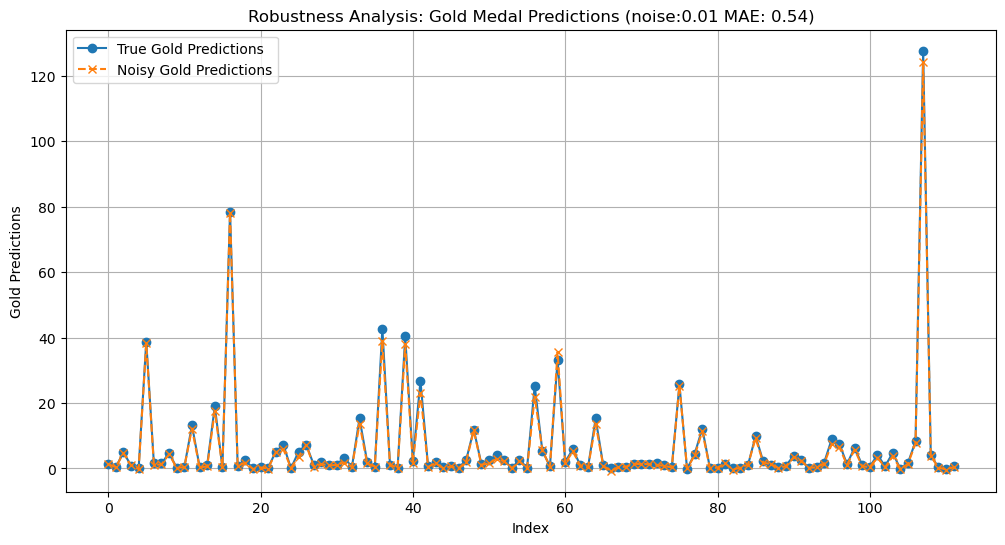

鲁棒性分析图像已保存: robustness_analysis_0.01.png


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Load noisy data
noisy_data_path = 'noisy_df_0.05.csv'
noisy_data = pd.read_csv(noisy_data_path)

# Load the true (noise-free) data (ensure the correct file path is provided)
true_data_path = 'feature_Noc.csv'  # Replace with your actual true data path
true_data = pd.read_csv(true_data_path)

# Initialize the model
model = OlympicPredictionModel()

# Set the testing time range
start_year = 1964
end_year = 2028

# Train and predict on the true data
results_true = model.train_and_predict_period(true_data, start_year, end_year)

# Train and predict on the noisy data
results_noisy = model.train_and_predict_period(noisy_data, start_year, end_year)

# Extract gold medal prediction results
true_gold_predictions = results_true["Gold_Prediction"].values
noisy_gold_predictions = results_noisy["Gold_Prediction"].values

# Calculate robustness metrics (e.g., Mean Absolute Error)
mae_gold = mean_absolute_error(true_gold_predictions, noisy_gold_predictions)

# Plot the prediction results comparison
plt.figure(figsize=(12, 6))
plt.plot(true_gold_predictions, label="True Gold Predictions", marker="o")
plt.plot(noisy_gold_predictions, label="Noisy Gold Predictions", marker="x", linestyle="--")
plt.title(f"Robustness Analysis: Gold Medal Predictions (noise:0.05 MAE: {mae_gold:.2f})")
plt.xlabel("Index")
plt.ylabel("Gold Predictions")
plt.legend()
plt.grid(True)

# Save the plot
output_image_path = "robustness_analysis_0.05.png"
plt.savefig(output_image_path)
plt.show()

# Print the output file path
print(f"Robustness analysis image saved at: {output_image_path}")


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 373.2229 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 361.9753 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 350.6274 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 352.8846 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 351.7414 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 343.7153 - learning_rate: 0.0010
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 344.8633 - learning_rate: 0.0010
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 291.2716 - learning_rate: 0.0010
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 310.6287 - learning_rate: 0.0010
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 345.1113 - learning_rate: 0.0010


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 484.4933 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 256.7869 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 230.2622 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 303.5830 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 331.1193 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 373.8058 - learning_rate: 0.0010
Epoch 7/10
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 400.1276
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 396.3455 - learning_rate: 0.0010
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 397.0706 - learning_rate: 5.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 320.2278 - learning_rate: 5.0000e-04
Epoch 10/10
35/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

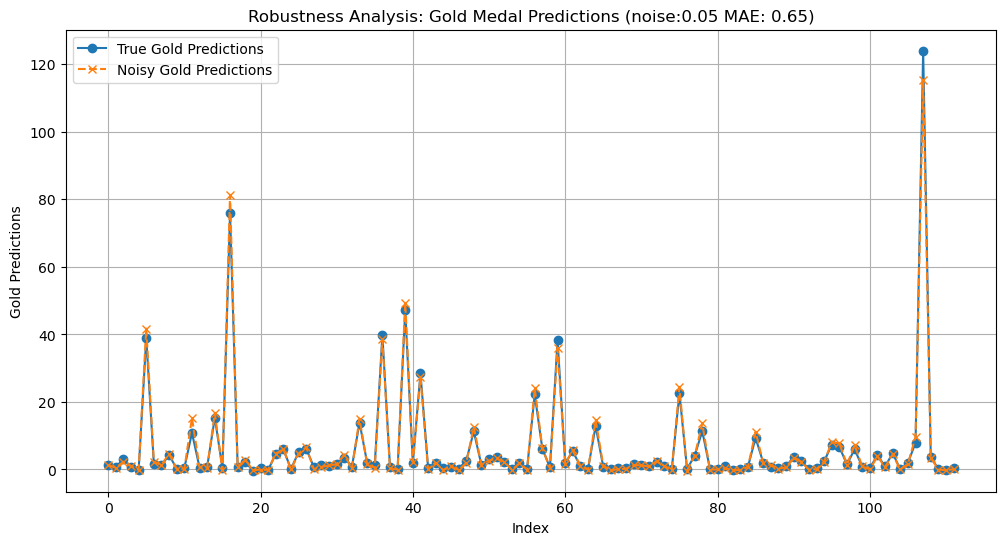

鲁棒性分析图像已保存: robustness_analysis_0.05.png


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Load noisy data
noisy_data_path = 'noisy_df_0.01.csv'
noisy_data = pd.read_csv(noisy_data_path)

# Load the true (noise-free) data (ensure the correct file path is provided)
true_data_path = 'feature_Noc.csv'  # Replace with your actual true data path
true_data = pd.read_csv(true_data_path)

# Initialize the model
model = OlympicPredictionModel()

# Set the testing time range
start_year = 1964
end_year = 2028

# Train and predict on the true data
results_true = model.train_and_predict_period(true_data, start_year, end_year)

# Train and predict on the noisy data
results_noisy = model.train_and_predict_period(noisy_data, start_year, end_year)

# Extract gold medal prediction results
true_gold_predictions = results_true["Gold_Prediction"].values
noisy_gold_predictions = results_noisy["Gold_Prediction"].values

# Calculate robustness metrics (e.g., Mean Absolute Error)
mae_gold = mean_absolute_error(true_gold_predictions, noisy_gold_predictions)

# Plot the prediction results comparison
plt.figure(figsize=(12, 6))
plt.plot(true_gold_predictions, label="True Gold Predictions", marker="o")
plt.plot(noisy_gold_predictions, label="Noisy Gold Predictions", marker="x", linestyle="--")
plt.title(f"Robustness Analysis: Gold Medal Predictions (noise:0.01 MAE: {mae_gold:.2f})")
plt.xlabel("Index")
plt.ylabel("Gold Predictions")
plt.legend()
plt.grid(True)

# Save the plot
output_image_path = "robustness_analysis_0.01.png"
plt.savefig(output_image_path)
plt.show()

# Print the output file path
print(f"Robustness analysis image saved at: {output_image_path}")


Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 422.9943 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 288.0035 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 420.8405 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 437.2202 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 260.7756 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 348.3462 - learning_rate: 0.0010
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 303.4026 - learning_rate: 0.0010
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 290.2729 - learning_rate: 0.0010
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 308.1647 - learning_rate: 0.0010
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 241.5954 - learning_rate: 0.0010


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 360.1539 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 279.8052 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 342.8825 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 401.8111 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 296.2573 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 285.6099 - learning_rate: 0.0010
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 259.2046 - learning_rate: 0.0010
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 348.4796 - learning_rate: 0.0010
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 320.1003 - learning_rate: 0.0010
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 274.8452 - learning_rate: 0.0010


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

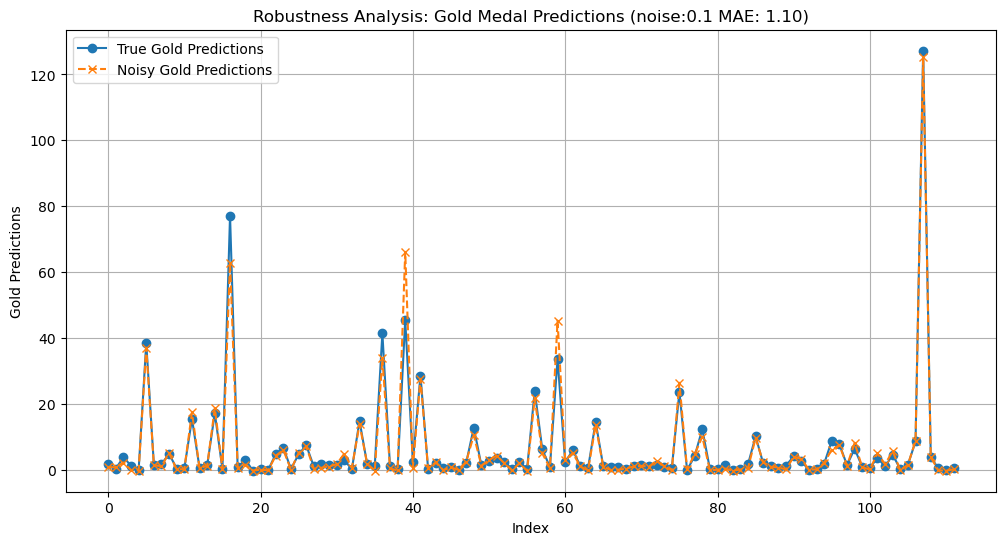

Robustness analysis image saved at: robustness_analysis_0.1.png


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Load noisy data
noisy_data_path = 'noisy_df_0.1.csv'
noisy_data = pd.read_csv(noisy_data_path)

# Load the true (noise-free) data (ensure the correct file path is provided)
true_data_path = 'feature_Noc.csv'  # Replace with your actual true data path
true_data = pd.read_csv(true_data_path)

# Initialize the model
model = OlympicPredictionModel()

# Set the testing time range
start_year = 1964
end_year = 2028

# Train and predict on the true data
results_true = model.train_and_predict_period(true_data, start_year, end_year)

# Train and predict on the noisy data
results_noisy = model.train_and_predict_period(noisy_data, start_year, end_year)

# Extract gold medal prediction results
true_gold_predictions = results_true["Gold_Prediction"].values
noisy_gold_predictions = results_noisy["Gold_Prediction"].values

# Calculate robustness metrics (e.g., Mean Absolute Error)
mae_gold = mean_absolute_error(true_gold_predictions, noisy_gold_predictions)

# Plot the prediction results comparison
plt.figure(figsize=(12, 6))
plt.plot(true_gold_predictions, label="True Gold Predictions", marker="o")
plt.plot(noisy_gold_predictions, label="Noisy Gold Predictions", marker="x", linestyle="--")
plt.title(f"Robustness Analysis: Gold Medal Predictions (noise:0.1 MAE: {mae_gold:.2f})")
plt.xlabel("Index")
plt.ylabel("Gold Predictions")
plt.legend()
plt.grid(True)

# Save the plot
output_image_path = "robustness_analysis_0.1.png"
plt.savefig(output_image_path)
plt.show()

# Print the output file path
print(f"Robustness analysis image saved at: {output_image_path}")


Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 353.0371 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 324.7179 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 261.0950 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 302.4883 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 345.8969 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 225.4939 - learning_rate: 0.0010
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 280.9138 - learning_rate: 0.0010
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 350.5537 - learning_rate: 0.0010
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 258.5254 - learning_rate: 0.0010
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 324.7045 - learning_rate: 0.0010


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 260.2553 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 343.4894 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 267.4009 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 323.3080 - learning_rate: 0.0010
Epoch 5/10
34/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 430.0678
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 410.5441 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 378.6251 - learning_rate: 5.0000e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 299.9252 - learning_rate: 5.0000e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 410.0955 - learning_rate: 5.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 316.8053 - learning_rate: 5.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

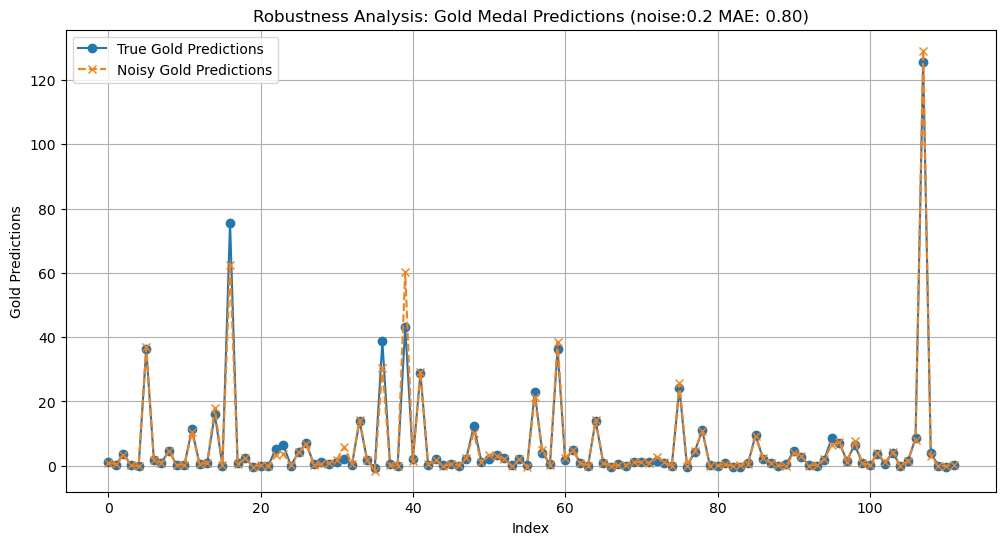

Robustness analysis image saved at: robustness_analysis_0.2.png


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Load noisy data
oisy_data_path = 'noisy_df_0.2.csv'
noisy_data = pd.read_csv(noisy_data_path)

# Load the true (noise-free) data (ensure the correct file path is provided)
true_data_path = 'feature_Noc.csv'  # Replace with your actual true data path
true_data = pd.read_csv(true_data_path)

# Initialize the model
model = OlympicPredictionModel()

# Set the testing time range
start_year = 1964
end_year = 2028

# Train and predict on the true data
results_true = model.train_and_predict_period(true_data, start_year, end_year)

# Train and predict on the noisy data
results_noisy = model.train_and_predict_period(noisy_data, start_year, end_year)

# Extract gold medal prediction results
true_gold_predictions = results_true["Gold_Prediction"].values
noisy_gold_predictions = results_noisy["Gold_Prediction"].values

# Calculate robustness metrics (e.g., Mean Absolute Error)
mae_gold = mean_absolute_error(true_gold_predictions, noisy_gold_predictions)

# Plot the prediction results comparison
plt.figure(figsize=(12, 6))
plt.plot(true_gold_predictions, label="True Gold Predictions", marker="o")
plt.plot(noisy_gold_predictions, label="Noisy Gold Predictions", marker="x", linestyle="--")
plt.title(f"Robustness Analysis: Gold Medal Predictions (noise:0.2 MAE: {mae_gold:.2f})")
plt.xlabel("Index")
plt.ylabel("Gold Predictions")
plt.legend()
plt.grid(True)

# Save the plot
output_image_path = "robustness_analysis_0.2.png"
plt.savefig(output_image_path)
plt.show()

# Print the output file path
print(f"Robustness analysis image saved at: {output_image_path}")


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 371.3227 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 356.8603 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 401.8588 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 287.9211 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 347.7540 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 270.3031 - learning_rate: 0.0010
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 334.4130 - learning_rate: 0.0010
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 307.2533 - learning_rate: 0.0010
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 344.5073 - learning_rate: 0.0010
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 326.5699 - learning_rate: 0.0010


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 339.6251 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 328.2843 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 346.7976 - learning_rate: 0.0010
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 336.9565 - learning_rate: 0.0010
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 266.5528 - learning_rate: 0.0010
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 301.9036 - learning_rate: 0.0010
Epoch 7/10
31/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 341.5619
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 342.0701 - learning_rate: 0.0010
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 277.3203 - learning_rate: 5.0000e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 387.8417 - learning_rate: 5.0000e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


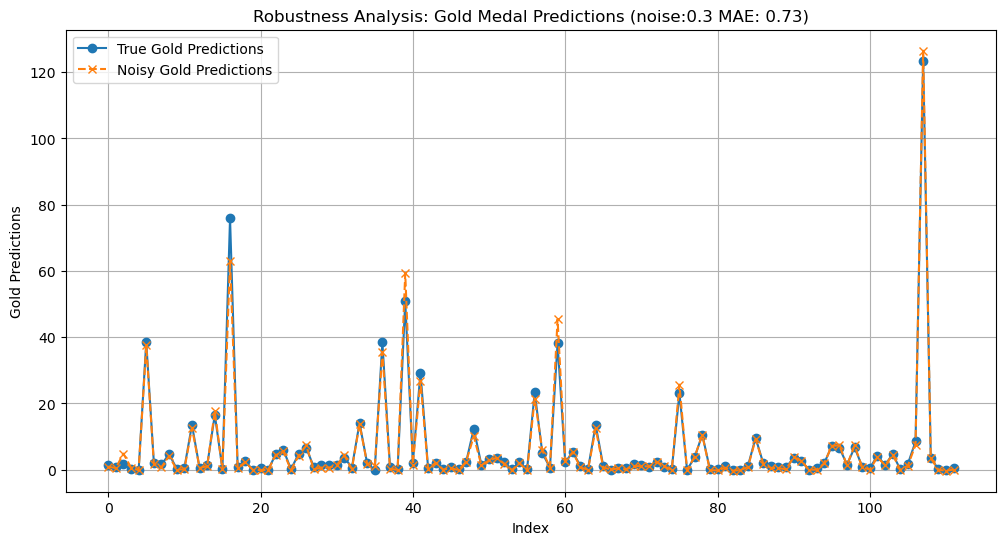

Robustness analysis image saved at: robustness_analysis_0.3.png


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Load noisy data
oisy_data_path = 'noisy_df_0.3.csv'
noisy_data = pd.read_csv(noisy_data_path)

# Load the true (noise-free) data (ensure the correct file path is provided)
true_data_path = 'feature_Noc.csv'  # Replace with your actual true data path
true_data = pd.read_csv(true_data_path)

# Initialize the model
model = OlympicPredictionModel()

# Set the testing time range
start_year = 1964
end_year = 2028

# Train and predict on the true data
results_true = model.train_and_predict_period(true_data, start_year, end_year)

# Train and predict on the noisy data
results_noisy = model.train_and_predict_period(noisy_data, start_year, end_year)

# Extract gold medal prediction results
true_gold_predictions = results_true["Gold_Prediction"].values
noisy_gold_predictions = results_noisy["Gold_Prediction"].values

# Calculate robustness metrics (e.g., Mean Absolute Error)
mae_gold = mean_absolute_error(true_gold_predictions, noisy_gold_predictions)

# Plot the prediction results comparison
plt.figure(figsize=(12, 6))
plt.plot(true_gold_predictions, label="True Gold Predictions", marker="o")
plt.plot(noisy_gold_predictions, label="Noisy Gold Predictions", marker="x", linestyle="--")
plt.title(f"Robustness Analysis: Gold Medal Predictions (noise:0.3 MAE: {mae_gold:.2f})")
plt.xlabel("Index")
plt.ylabel("Gold Predictions")
plt.legend()
plt.grid(True)

# Save the plot
output_image_path = "robustness_analysis_0.3.png"
plt.savefig(output_image_path)
plt.show()

# Print the output file path
print(f"Robustness analysis image saved at: {output_image_path}")


In [14]:
class OlympicPredictionModel:
    from sklearn.neural_network import MLPRegressor

    def __init__(self, lambda_weight=0.3, mu_weight=0.85, learning_rate=0.001):
        self.lambda_weight = lambda_weight
        self.mu_weight = mu_weight
        self.learning_rate = learning_rate
        self.classifier = RandomForestClassifier(n_estimators=200)
        self.regressor1 = self.MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
        self.regressor2 = self.MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
        self.lstm_model = None

    @staticmethod
    def Country_classification(year, Noc_x, data):
        historical_data = data[data['Year'] <= year]
        country_total = historical_data[historical_data['NOC_x'] == Noc_x]['Name_Count'].sum()
        all_countries = historical_data.groupby('NOC_x')['Name_Count'].sum()
        threshold = all_countries.quantile(0.2)
        return country_total <= threshold

    def calculate_w4_vector(self, country_change, athlete_change, event_changes):
        w1 = np.sum(country_change, axis=1).astype(np.float64)
        w2 = np.sum(athlete_change, axis=1).astype(np.float64)
        w3 = np.sum(event_changes, axis=1).astype(np.float64)
        w4 = np.divide(0.2 * w1 + 0.8 * w2, w3, out=np.zeros_like(w3, dtype=np.float64), where=w3 != 0)
        return w4

    def preprocess_data(self, data):
        year_mapping = pd.read_csv("year_transmition_reference.csv")
        year_dict = dict(zip(year_mapping['evaluating_year'], year_mapping['use_data_from']))

        features_list = []
        for idx, row in data.iterrows():
            current_year = row['Year']
            reference_year = year_dict.get(current_year, current_year)
            reference_data = data[data['Year'] == reference_year]

            if len(reference_data) > 0:
                ref_row = reference_data[reference_data['NOC_x'] == row['NOC_x']]
                ref_row = ref_row.iloc[0] if len(ref_row) > 0 else row
            else:
                ref_row = row

            score_rate_list = np.array(eval(ref_row['Score_Rate_List']))
            score_list = np.array(eval(ref_row['Score_List']), dtype=np.float64)
            participants_list = np.array(eval(ref_row['Participants_List']), dtype=np.float64)

            v4_ = np.sum(score_rate_list)
            v5_ = np.sum(participants_list)
            v8_ = np.sum(np.divide(score_list, participants_list, out=np.zeros_like(score_list, dtype=np.float64), where=participants_list > 0))

            country_change = np.array(eval(ref_row['CountryChange']))
            athlete_change = np.array(eval(ref_row['AthleteChange']))
            event_changes = np.array(eval(ref_row['Event_Changes']))
            w4_ = self.calculate_w4_vector(country_change.reshape(1, -1), athlete_change.reshape(1, -1), event_changes.reshape(1, -1))[0]

            v8_w4 = np.sum(np.multiply(np.divide(score_list, participants_list, out=np.zeros_like(score_list, dtype=np.float64), where=participants_list > 0), w4_))

            v1 = ref_row['if_host']
            v6 = ref_row['Gold_prev'] if pd.notna(ref_row['Gold_prev']) else 0
            v7 = ref_row['distance']
            v3_ = ref_row['Score']
            v3_w4 = np.sum(np.multiply(score_list, w4_))

            w3_ = np.sum(event_changes)

            features = {
                'features_a': [v5_, v8_, v8_w4],
                'features_b': [v1, v5_, v6, v7, v3_, v3_w4, v8_],
                'features_c': [v1, v5_, v6, v7, v3_, v3_w4, v8_],
                'features_all': [v1, v3_, v4_, v5_, v6, v7, v8_, w3_, w4_]
            }
            features_list.append(features)

        features_a = np.array([f['features_a'] for f in features_list])
        features_b = np.array([f['features_b'] for f in features_list])
        features_c = np.array([f['features_c'] for f in features_list])
        features_all = np.array([f['features_all'] for f in features_list])

        labels = (data['Total_Medals'] > 0).astype(int).values
        medal_expectation = data['Total_Medals'].values
        gold_expectation = data['Gold'].values

        scaler = StandardScaler()
        features_a_scaled = scaler.fit_transform(features_a)
        features_b_scaled = scaler.fit_transform(features_b)
        features_c_scaled = scaler.fit_transform(features_c)
        features_all_scaled = scaler.fit_transform(features_all)

        return features_a_scaled, features_b_scaled, features_c_scaled, features_all_scaled, labels, medal_expectation, gold_expectation

    def train_classifier(self, features_a, features_all, labels, data):
        years = data['Year'].values
        nocs = data['NOC_x'].values

        is_small_countries = np.array([self.Country_classification(year, noc, data)
                                     for year, noc in zip(years, nocs)])

        final_features = np.zeros((len(labels), features_all.shape[1]))
        small_countries_mask = is_small_countries

        final_features[small_countries_mask] = (1 - self.lambda_weight) * features_all[small_countries_mask]
        final_features[small_countries_mask, :features_a.shape[1]] += self.lambda_weight * features_a[small_countries_mask]

        final_features[~small_countries_mask] = features_all[~small_countries_mask]

        self.classifier.fit(final_features, labels)
        self.classifier_output = self.classifier.predict_proba(final_features)

    def train_regressor1(self, features_b, medal_expectation):
        classifier_probabilities = self.classifier_output[:, 1]
        input_features = np.hstack([classifier_probabilities.reshape(-1, 1), features_b])
        self.regressor1.fit(input_features, medal_expectation)

    def train_regressor2(self, features_c, gold_expectation):
        """
        Train the second regressor (for gold medal predictions) and compute training accuracy.
        """
        classifier_probabilities = self.classifier_output[:, 1]
        input_features_reg1 = np.hstack([classifier_probabilities.reshape(-1, 1), features_c])
        medal_expectation = self.regressor1.predict(input_features_reg1)

        input_features = np.hstack([
            (1 - self.mu_weight) * medal_expectation.reshape(-1, 1),
            self.mu_weight * features_c
        ])
        self.regressor2.fit(input_features, gold_expectation)

        # Calculate gold prediction accuracy on the training set
        train_gold_pred = self.regressor2.predict(input_features)
        gold_accuracy = np.mean(np.abs(train_gold_pred / 2 - gold_expectation) < 2)

        print(f"Training Gold Prediction Accuracy: {gold_accuracy:.2f}")

# Example usage
data = pd.read_csv("feature_Noc.csv")  # Replace with your dataset
model = OlympicPredictionModel()

# Preprocess data
features_a, features_b, features_c, features_all, labels, medal_expectation, gold_expectation = model.preprocess_data(data)

# Train the classifier
model.train_classifier(features_a, features_all, labels, data)

# Train the first regressor
model.train_regressor1(features_b, medal_expectation)

# Train the second regressor and output training accuracy
model.train_regressor2(features_c, gold_expectation)


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Gold Prediction Accuracy: 0.72
